In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
import scipy.io

from util import *

In [2]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:2'

In [3]:
data = scipy.io.loadmat('./cylinder_nektar_wake.mat')

In [4]:
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

idx = np.random.choice(N*T,2500, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]

x_train = np.expand_dims(np.tile(x_train[:], (5)) ,-1)
y_train = np.expand_dims(np.tile(y_train[:], (5)) ,-1)
t_train = make_time_sequence(t_train, num_step=5, step=1e-2)

x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True).to(device)
t_train = torch.tensor(t_train, dtype=torch.float32, requires_grad=True).to(device)
u_train = torch.tensor(u_train, dtype=torch.float32, requires_grad=True).to(device)
v_train = torch.tensor(v_train, dtype=torch.float32, requires_grad=True).to(device)

In [5]:
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x) + self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        
    def forward(self, x):
        x2 = self.act1(x)
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs): 
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)


class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)



class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        super(PINNsformer, self).__init__()

        self.linear_emb = nn.Linear(3, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        ])

    def forward(self, x, y, t):
        src = torch.cat((x,y,t), dim=-1)
        src = self.linear_emb(src)
        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        return output
    

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [6]:
model = PINNsformer(d_out=2, d_hidden=512, d_model=32, N=1, heads=2).to(device)
model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

n_params = get_n_params(model)

print(model)
print(get_n_params(model))

PINNsformer(
  (linear_emb): Linear(in_features=3, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

/tmp/ipykernel_1464206/3795666123.py:113: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [7]:
loss_track = []

for i in tqdm(range(1000)):
    def closure():
        psi_and_p = model(x_train, y_train, t_train)
        psi = psi_and_p[:,:,0:1]
        p = psi_and_p[:,:,1:2]

        u = torch.autograd.grad(psi, y_train, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
        v = - torch.autograd.grad(psi, x_train, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]

        u_t = torch.autograd.grad(u, t_train, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x_train, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, y_train, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u, x_train, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u, y_train, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0]

        v_t = torch.autograd.grad(v, t_train, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_x = torch.autograd.grad(v, x_train, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_y = torch.autograd.grad(v, y_train, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v, x_train, grad_outputs=torch.ones_like(v_x), retain_graph=True, create_graph=True)[0]
        v_yy = torch.autograd.grad(v, y_train, grad_outputs=torch.ones_like(v_y), retain_graph=True, create_graph=True)[0]

        p_x = torch.autograd.grad(p, x_train, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        p_y = torch.autograd.grad(p, y_train, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]

        f_u = u_t + (u*u_x + v*u_y) + p_x - 0.01*(u_xx + u_yy) 
        f_v = v_t + (u*v_x + v*v_y) + p_y - 0.01*(v_xx + v_yy)

        loss = torch.mean((u[:,0] - u_train)**2) + torch.mean((v[:,0] - v_train)**2) + torch.mean(f_u**2) + torch.mean(f_v**2)

        loss_track.append(loss.item())

        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

100%|██████████| 1000/1000 [1:30:19<00:00,  5.42s/it] 


In [8]:
np.save('./ns_loss_pinnsformer.npy', loss_track)
torch.save(model.state_dict(), './ns_pinnsformer.pt')

loss_track[-1]

6.660704002570128e-06

In [9]:
 # Test Data
snap = np.array([100])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]

u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]

x_star = np.expand_dims(np.tile(x_star[:], (5)) ,-1)
y_star = np.expand_dims(np.tile(y_star[:], (5)) ,-1)
t_star = make_time_sequence(t_star, num_step=5, step=1e-2)

x_star = torch.tensor(x_star, dtype=torch.float32, requires_grad=True).to(device)
y_star = torch.tensor(y_star, dtype=torch.float32, requires_grad=True).to(device)
t_star = torch.tensor(t_star, dtype=torch.float32, requires_grad=True).to(device)

In [10]:
# with torch.no_grad():
psi_and_p = model(x_star, y_star, t_star)
psi = psi_and_p[:,:,0:1]
p_pred = psi_and_p[:,:,1:2]

u_pred = torch.autograd.grad(psi, x_star, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]
v_pred = - torch.autograd.grad(psi, y_star, grad_outputs=torch.ones_like(psi), retain_graph=True, create_graph=True)[0]

u_pred = u_pred.cpu().detach().numpy()[:,0]
v_pred = v_pred.cpu().detach().numpy()[:,0]
p_pred = p_pred.cpu().detach().numpy()[:,0]


error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)

In [11]:
error_p

0.280059179356535

In [12]:
error_p = np.linalg.norm(p_star-p_pred,1)/np.linalg.norm(p_star,1)
error_p

0.38430213355696186

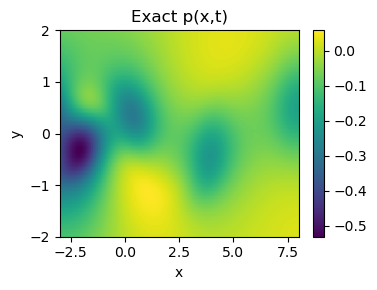

In [13]:
plt.figure(figsize=(4,3))
plt.imshow((p_star).reshape(50,100), extent=[-3,8,-2,2], aspect='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact p(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./ns_exact.png')
plt.show()

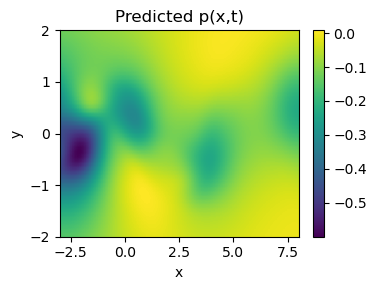

In [14]:
plt.figure(figsize=(4,3))
plt.imshow((p_pred).reshape(50,100), extent=[-3,8,-2,2], aspect='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted p(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./ns_pinnsformer_pred.png')
plt.show()

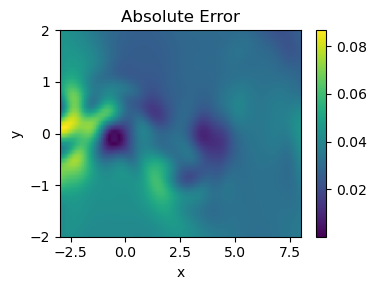

In [15]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(p_pred-p_star).reshape(50,100), extent=[-3,8,-2,2], aspect='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./ns_pinnsformer_error.png')
plt.show()